In [1]:
# The MIT License (MIT) Copyright (c) 2024 Andrés Urbano Andrea, Núñez Quintana Luis Axel & Ramírez Gómez María Emilia
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Andrea585976/ArtEmis-ProyectoPLN/blob/main/models/artemis_transformers.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Image Captioning Transformer


- This notebook explores the combination of Transformers and CNNs for image captioning, showcasing their remarkable ability to generate descriptive textual captions based on visual content.

## 0. Dependencias

In [2]:
from collections import Counter
import numpy as np
import os
import pandas as pd
import pathlib
import PIL
from PIL import Image
import random
import time
import torch
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
import torchvision
from torchvision import transforms

torch.__version__

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

'2.3.0+cu121'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

In [4]:
# Download dataset
if not os.path.exists('img.zip'):
  !wget https://github.com/Andrea585976/ArtEmis-ProyectoPLN/raw/main/img.zip
  !unzip img.zip
  !rm img.zip
if not os.path.exists('romanticism_dataset.csv'):
  !wget https://raw.githubusercontent.com/Andrea585976/ArtEmis-ProyectoPLN/main/romanticism_dataset.csv


Streaming output truncated to the last 5000 lines.
  inflating: img/nikolai-ge_love-of-vestal.jpg  
  inflating: img/camille-corot_orpheus-leading-eurydice-from-the-underworld-1861.jpg  
  inflating: img/caspar-david-friedrich_easter-morning.jpg  
  inflating: img/konstantin-makovsky_beauty-preparing-to-bathe.jpg  
  inflating: img/john-everett-millais_the-royalist.jpg  
  inflating: img/pierre-paul-prud'hon_madame-simon.jpg  
  inflating: img/konstantin-makovsky_portrait-of-the-count-nikolay-muravyov-amursky.jpg  
  inflating: img/jean-leon-gerome_pifferari2.jpg  
  inflating: img/gustave-dore_daniel-confounds-the-priests-of-bel.jpg  
  inflating: img/john-crome_carrow-abbey-norwich-1805.jpg  
  inflating: img/nikolai-ge_death-of-virginia-study-1.jpg  
  inflating: img/gustave-dore_the-inferno-canto-32-1.jpg  
  inflating: img/john-constable_shoreham-bay-near-brighton-1824.jpg  
  inflating: img/william-turner_view-of-saint-germain-ea-laye-and-its-chateau.jpg  
  inflating: img/ivan-a

In [5]:
# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv('romanticism_dataset.csv')
print(df.columns)

images = df.loc[:, ['painting', 'utterance']]
images['painting'] = images['painting'].apply(lambda x: 'img/' + x + '.jpg')

images.head(10)

Index(['painting', 'emotion', 'utterance', 'repetition'], dtype='object')


painting  \
0  img/viktor-vasnetsov_ivan-tsarevich-riding-the...   
1  img/viktor-vasnetsov_ivan-tsarevich-riding-the...   
2            img/william-turner_fishermen-at-sea.jpg   
3            img/william-turner_fishermen-at-sea.jpg   
4              img/paul-cezanne_the-oilmill-1871.jpg   
5  img/n.c.-wyeth_merlin-taking-away-the-infant-a...   
6       img/orest-kiprensky_the-family-of-satyrs.jpg   
7  img/sir-lawrence-alma-tadema_strigils-and-spon...   
8         img/orest-kiprensky_putto-with-a-globe.jpg   
9     img/sir-lawrence-alma-tadema_pleading-1876.jpg   

                                           utterance  
0  The scene is quite beautiful and reminds me of...  
1  There is a sense of romance between the two pe...  
2  There is a spooky feel to this image, with the...  
3  The boat makes a dangerous journey alone at ni...  
4  The village looks very rudimentary with it's s...  
5  It looks like the baby is being taken for what...  
6    The imps playfully dance and sing to the music.  
7  The women appear quite interested in one anoth...  
8  The little boy is trying to roll the globe aro...  
9  The man laying down in this painting feels lik...

- Download images:

In [6]:
# Convertir df_subset en un arreglo NumPy sin nombres de columnas
images = images.values
images = sorted(images, key = lambda x: x[0])
len(images)

39069

- Dataset split

In [7]:
# split is made so that train and val dont have the same painting
num_val_samples = int(0.05 * len(images)) + 2
train_images = images[num_val_samples:]
val_images= images[:num_val_samples]
print(train_images[:1],val_images[-1:])
print(len(train_images), len(val_images))

[array(['img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg',
       'This is interesting because did the maiden find the child and return to the queen or did the queen just deliver while they were on a ride. Very interesting'],
      dtype=object)] [array(['img/arthur-hughes_the-beautiful-lady-without-pity-1863.jpg',
       'The look of two people in love.'], dtype=object)]
37114 1955


In [8]:
def generate_tuples(paths):
    tuples = []
    for image_path, text in paths:
        if os.path.exists(image_path):  # Verificar si la imagen existe en la ruta
            tuples.append((image_path, text.strip()))
    return tuples

train_tuples = generate_tuples(train_images)
val_tuples = generate_tuples(val_images)

len(train_tuples), len(val_tuples)

(36910, 1851)

In [9]:
for tuple in train_tuples[:2]:
    print(tuple)

('img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg', 'This is interesting because did the maiden find the child and return to the queen or did the queen just deliver while they were on a ride. Very interesting')
('img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg', 'The mother face looks excited to hold her baby for the first time')


## 2.- Pipeline

- Create vocabulary and tokenizer.

In [10]:
tokenizer = get_tokenizer('basic_english')

In [11]:
def build_vocab(text, tokenizer):
    counter = Counter()
    for _, string_ in text:
        counter.update(tokenizer(string_))
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


vocab = build_vocab(train_tuples, tokenizer)
vocab.set_default_index(0) # fix <ukn>

In [12]:
vocab_size = len(vocab)
vocab_size

16820

In [13]:
image_size = 128
batch_size = 64
maxlen = 36

PAD_IDX = vocab['<pad>']
BOS_IDX = vocab['<bos>']
EOS_IDX = vocab['<eos>']
PAD_IDX, BOS_IDX, EOS_IDX

(1, 2, 3)

- Reduce dataset size for simplicity

In [14]:
def data_process(text):
    data = []
    for x, y in text:
        tensor_ = torch.tensor(
            [vocab[token] for token in tokenizer(y)],
            dtype=torch.long
        )

        if tensor_.shape[0] < maxlen:
            data.append((x, tensor_))

    return data

train_data = data_process(train_tuples[:50000])
val_data = data_process(val_tuples[:1000])
len(train_data), len(val_data)

(35389, 961)

In [15]:
transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
])

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        image = Image.open(x_item).convert('RGB')
        image = transform(image)
        x.append(image)
        y.append(
            torch.cat([
                torch.tensor([BOS_IDX]),
                y_item,
                torch.tensor([EOS_IDX])
            ], dim=0)
        )

    x = torch.stack(x)
    y = pad_sequence(y, batch_first=True, padding_value=PAD_IDX)
    return x, y[:, :-1], y[:, 1:]

train_loader = DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                    shuffle=False, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
enc_batch, dec_batch, target_batch = next(iter(val_loader))
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 31]), torch.Size([64, 31]))

In [17]:
import matplotlib.pyplot as plt

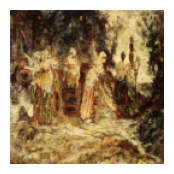

Ground truth: the bright colors and splashes of reds give this piece an energetic look , like the maidens in it are about to <unk> on a journey .    


In [18]:
def plot_img(img, target):
    image_array = img.permute(1, 2, 0).numpy()
    image_text = " ".join(
        [vocab.get_itos()[_] for _ in target]
    ).replace("<pad>", "").replace("<eos>", "")

    fig = plt.figure(figsize=(2, 2))

    # Plot the image
    plt.imshow(image_array)
    #plt.title(image_text)
    plt.axis('off')  # Optional: Turn off axes
    plt.show()
    print(f'Ground truth: {image_text}')

idx = 10
plot_img(enc_batch[idx], target_batch[idx])

## 3.- Model

### Feature extraction block
- Define a convolutional network for image feature extraction.

In [31]:
class DownBlockComp(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(DownBlockComp, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 3, 2, 1, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True),
        )

        self.direct = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.Conv2d(in_planes, out_planes, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True))

    def forward(self, feat):
        return (self.main(feat) + self.direct(feat)) / 2

In [32]:
class CNN(nn.Module):
    def __init__(self, filters=128, noise_dim=64):
        super(CNN, self).__init__()
        self.filters = filters
        self.down_block = nn.Sequential(
            nn.Conv2d(3, filters // 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(filters // 8), nn.LeakyReLU(0.2, inplace=True),
            DownBlockComp(filters // 8, filters // 4),
            DownBlockComp(filters // 4, filters // 2),
            DownBlockComp(filters // 2, filters),
            DownBlockComp(filters, filters),
            nn.Conv2d(filters, filters, 3, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.down_block(x)
        x = torch.permute(x, [0, 2, 3, 1]).view(B, -1, self.filters)
        return x


discriminator = CNN(256)
out_disc = discriminator(enc_batch)
out_disc.shape

torch.Size([64, 36, 256])

### Transformer block

In [33]:
class Attention(nn.Module):
    def __init__(self, dim, maxlen, n_heads=4, bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.wq = nn.Linear(dim, dim, bias = bias)
        self.wk = nn.Linear(dim, dim, bias = bias)
        self.wv = nn.Linear(dim, dim, bias = bias)

        self.wo = nn.Linear(dim, dim, bias = bias)
        self.register_buffer("bias", torch.tril(torch.ones(maxlen, maxlen)).view(1, 1, maxlen, maxlen))

    def forward(self, x, context=None):
        B, L, D = x.shape
        out_L = L
        q = self.wq(x)
        q = torch.reshape(q, [B, L, self.n_heads, -1])
        q = torch.permute(q, [0, 2, 1, 3])

        if context == None:
            k = self.wk(x)
            v = self.wv(x)
        else:
            k = self.wk(context)
            v = self.wv(context)
            B, L, D = k.shape

        k = torch.reshape(k, [B, L, self.n_heads, -1])
        k = torch.permute(k, [0, 2, 3, 1])
        v = torch.reshape(v, [B, L, self.n_heads, -1])
        v = torch.permute(v, [0, 2, 1, 3])

        qk = torch.matmul(q, k) * self.scale
        if context == None:
            qk = qk.masked_fill(self.bias[:,:,:L,:L] == 0, float('-inf'))

        attn = torch.softmax(qk, dim=-1)

        v_attn = torch.matmul(attn, v)
        v_attn = torch.permute(v_attn, [0, 2, 1, 3])
        v_attn = torch.reshape(v_attn, [B, out_L, D])

        x = self.wo(v_attn)
        return x


q_test = torch.ones([1, 8, 32])
k_test = torch.ones([1, 64, 32])
test_layer = Attention(32, maxlen, n_heads=4)
test_layer(q_test).shape, test_layer(q_test, k_test).shape

(torch.Size([1, 8, 32]), torch.Size([1, 8, 32]))

- Define Transformer:

In [42]:
class DecoderBlock(nn.Module):
    def __init__(self, dim, maxlen, heads=4, mlp_dim=512, rate=0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, maxlen)
        self.cross_attn = Attention(dim, maxlen)
        self.ln_2 = nn.LayerNorm(dim)
        self.ln_3 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(rate),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(rate),
        )

    def forward(self, x):
        inputs, context = x
        x = self.attn(inputs)
        skip1 = self.ln_1(x + inputs)
        x = self.cross_attn(skip1, context)
        skip2 = self.ln_2(x + skip1)
        return self.ln_3(self.mlp(skip2) + skip2)


test_layer = DecoderBlock(32, maxlen)
x_test = torch.ones([1, maxlen, 32])
test_layer([x_test, x_test]).shape

torch.Size([1, 36, 32])

- Define Transformer

In [43]:
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 31]), torch.Size([64, 31]))

### Transformer

In [44]:
class Transformer(nn.Module):
    def __init__(self, dim, vocab_size, maxlen, depth=3,
                 mlp_dim=512, rate=0.2):
        super().__init__()
        self.depth = depth
        self.embedding = nn.Embedding(vocab_size, dim)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, maxlen, dim))

        self.decoder = nn.ModuleList()
        for i in range(self.depth):
            self.decoder.append(DecoderBlock(dim, maxlen))

        self.head = nn.Linear(dim, vocab_size, bias=False)
        self.cnn = CNN(dim)

    def forward(self, x, context):
        B, L = x.shape
        x = self.embedding(x)
        x += self.pos_embedding[:, :L]

        context = self.cnn(context)
        for layer in self.decoder:
            x = layer([x, context])
        x = self.head(x)
        return x


model_dim = 64
mlp_dim = 128
depth = 3

transformer = Transformer(dim=model_dim, vocab_size=vocab_size,
          maxlen=maxlen, depth=depth, mlp_dim=mlp_dim)
output = transformer(dec_batch, enc_batch)
output.shape, target_batch.shape

(torch.Size([64, 31, 16820]), torch.Size([64, 31]))

## 4.- Training

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

transformer.to(device)

cuda:0


Transformer(
  (embedding): Embedding(16820, 64)
  (decoder): ModuleList(
    (0-2): 3 x DecoderBlock(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (cross_attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=512, bias=True)
        (1): G

In [46]:
optimizer = optim.Adam(transformer.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [47]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inp_enc, inp_dec, tar_dec in train_loader:
        tar_dec = tar_dec.reshape(-1)
        inp_enc = inp_enc.to(device)
        inp_dec = inp_dec.to(device)
        tar_dec = tar_dec.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inp_dec, inp_enc)
        outputs = outputs.view(-1, outputs.size(-1))
        loss = loss_fn(outputs, tar_dec)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [48]:
def generate(model, image, device, maxlen):
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        model.eval()
        idx = torch.tensor(BOS_IDX, dtype=torch.long)
        idx = idx.reshape([1, -1])

        for _ in range(maxlen):
            idx = idx.to(device)
            logits = model(idx, image)[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

            _, idx_next = torch.topk(probs, k=1, dim=-1)
            if vocab.get_itos()[idx_next] == '<eos>':
                break
            idx = torch.cat((idx, idx_next), dim=1)

    txt = " ".join(
        [vocab.get_itos()[_] for _ in idx[0]]
    )
    print(f'Generated text: {txt.replace("<bos>", "")}')


generate(transformer, enc_batch[idx], device, maxlen)

Generated text:  confronting presume principal cordination halos inscription chirps week claude displaced hypnotically waterways lordly mutilated\tortured\killed marching observor showcasing finality enraptured unomfortable yoked dim/bright album attempt =l flimsy bleak issuing boil anyways seaport heck owww fun declaration needs


In [49]:
epochs = 7

for epoch in range(epochs):
    train(transformer, device, train_loader, optimizer, epoch)
    generate(transformer, enc_batch[idx], device, maxlen)


Time for epoch 0 is 189.4636 sec Train loss: 5.2271
Generated text:  the man is wearing a man in the woman ' s face is very sad .

Time for epoch 1 is 196.0578 sec Train loss: 4.3937
Generated text:  the man is wearing a lot of a woman in a white dress .

Time for epoch 2 is 191.3287 sec Train loss: 4.1357
Generated text:  the woman is wearing a lot of a woman in the middle of the painting .

Time for epoch 3 is 194.5855 sec Train loss: 3.9636
Generated text:  the woman looks like she is in the middle of the woman .

Time for epoch 4 is 188.7722 sec Train loss: 3.8292
Generated text:  the woman is looking at the flowers in the middle of her dress

Time for epoch 5 is 197.1358 sec Train loss: 3.7153
Generated text:  the woman looks like she is in a very sad way .

Time for epoch 6 is 186.6899 sec Train loss: 3.6153
Generated text:  the woman is wearing a red dress and the flowers are very beautiful .


- Test the model on validation images.

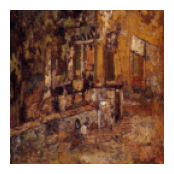

Ground truth: it looks like an abandoned cabin out in the woods .                    
Generated text:  the woman in the painting looks like she is in pain .


In [50]:
idx = 47
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], device, maxlen)

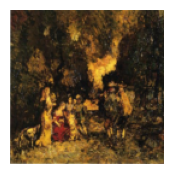

Ground truth: the people in the painting appear to be having a peaceful gathering .                  
Generated text:  the woman is wearing a red dress and the colors are very beautiful .


In [51]:
idx = 63
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], device, maxlen)

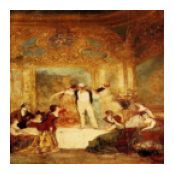

Ground truth: it appears to be a brothel . two women hanging on one man , dressed well , spending his money to have his way with them .    
Generated text:  the woman ' s expression is very beautiful and the colors are beautiful .


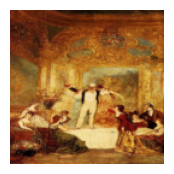

Ground truth: looks like these people are having fun and relaxing                      
Generated text:  the woman is wearing a red dress and her head is very pretty


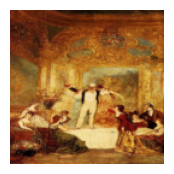

Ground truth: the gestures are clear and the reds come through well                     
Generated text:  the woman is wearing a red dress and her head is very pretty


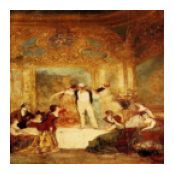

Ground truth: i would love to join this man in revelry . also , very ornate painting .               
Generated text:  the woman ' s expression is very beautiful and the colors are beautiful .


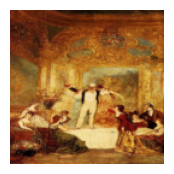

Ground truth: looks like a game of <unk> at a party . they seem excited and irritated at the same time .           
Generated text:  the woman is wearing a red dress and her head is very pretty


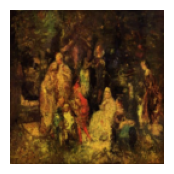

Ground truth: the dark colors , the postures of the figures , and the body gestures toward one another <unk> a feeling they are in a sad mood .    
Generated text:  the woman in the painting looks like she is in pain .


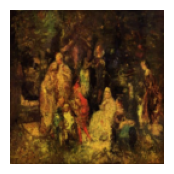

Ground truth: this just looks too crowded and messy .                       
Generated text:  the woman in the painting looks like she is in pain .


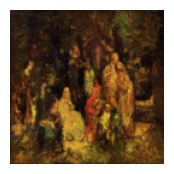

Ground truth: its a nice painting but it doesnt give me any strong feelings one way or another .              
Generated text:  the people in the painting look like they are in pain .


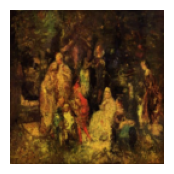

Ground truth: all this colors is making feel fear and sadness . you cant see faces of the people .             
Generated text:  the woman in the painting looks like she is in pain .


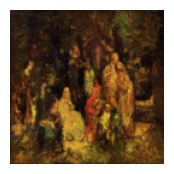

Ground truth: this painting does not evoke any strong emotion in me .                    
Generated text:  the people in the painting look like they are in pain .


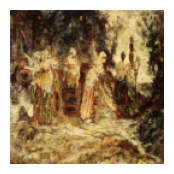

Ground truth: the bright colors and splashes of reds give this piece an energetic look , like the maidens in it are about to <unk> on a journey .    
Generated text:  the woman is wearing a red dress and the flowers are very beautiful .


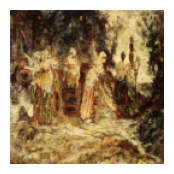

Ground truth: it looks like something gruesome is happening .                       
Generated text:  the woman is wearing a red dress and the flowers are very beautiful .


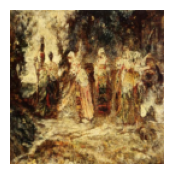

Ground truth: puritanical kind of imagery this picture invokes .                       
Generated text:  the woman is wearing a red dress and the flowers are very beautiful .


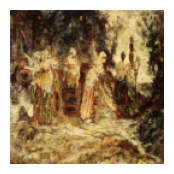

Ground truth: its hard to tell but it looks like they are <unk> something .                  
Generated text:  the woman is wearing a red dress and the flowers are very beautiful .


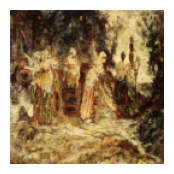

Ground truth: the faded colors and historical appearance of the figures make me feel very comfortable and peaceful about the painting .           
Generated text:  the woman is wearing a red dress and the flowers are very beautiful .


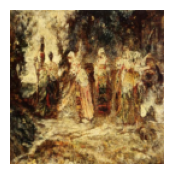

Ground truth: its a little scary with how grainy it is , there is something haunting about it like the scary stories to tell in the dark style artwork .   
Generated text:  the woman is wearing a red dress and the flowers are very beautiful .


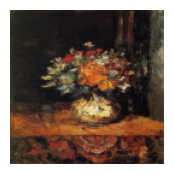

Ground truth: painted really well                            
Generated text:  the woman ' s expression is very sad and the way she is holding her head .


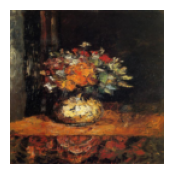

Ground truth: the dark colors reminds me of death and gloom                      
Generated text:  the woman ' s expression is very sad and the way she is holding her head .


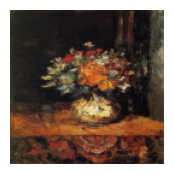

Ground truth: the image contains wonderful elements throughout it .                       
Generated text:  the woman ' s expression is very sad and the way she is holding her head .


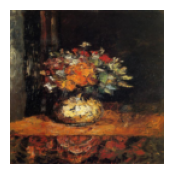

Ground truth: bright still life done , it appears , with a pallet knife in <unk> . gorgeous colors and such depth !          
Generated text:  the woman ' s expression is very sad and the way she is holding her head .


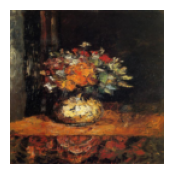

Ground truth: the colors are dark and dreary . also , the bouquet reminds me of funeral flowers .              
Generated text:  the woman ' s expression is very sad and the way she is holding her head .


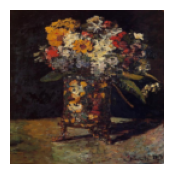

Ground truth: floral , seems mysterious due to contrasting background                       
Generated text:  the woman is wearing a red dress and the red on her head is very well done .


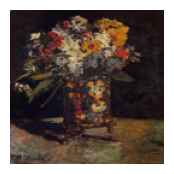

Ground truth: since this is a still life , there isn ' t much conflict , and the flowers look fresh , so it just feels nice .     
Generated text:  the man in the painting looks like he is in pain .


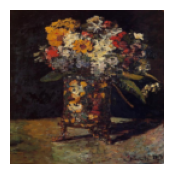

Ground truth: lovely colors and the brush strokes add a great deal of beauty to this painting .               
Generated text:  the woman is wearing a red dress and the red on her head is very well done .


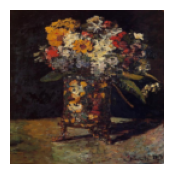

Ground truth: lovely flowers , warm colors , and pretty brushstrokes make this very appealing to look at .              
Generated text:  the woman is wearing a red dress and the red on her head is very well done .


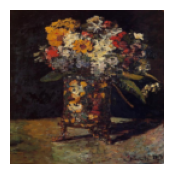

Ground truth: the vase going for a walk                         
Generated text:  the woman is wearing a red dress and the red on her head is very well done .


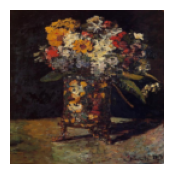

Ground truth: i like the bright colors on the dark background , very appealing to look at                
Generated text:  the woman is wearing a red dress and the red on her head is very well done .


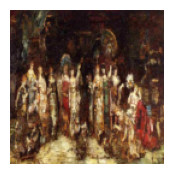

Ground truth: the painting is just dull and lifeless .                       
Generated text:  the people in the painting look like they are in pain .


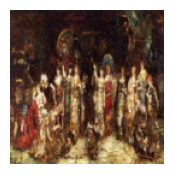

Ground truth: looks like ladies at a social outing .                       
Generated text:  the people in the painting look like they are in pain .


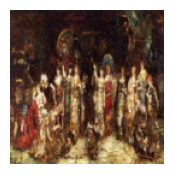

Ground truth: it ' s hard to make out the shapes in this older piece but the color and shadow make it interesting          
Generated text:  the people in the painting look like they are in pain .


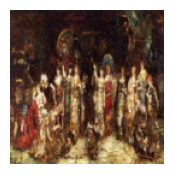

Ground truth: this is a very traditional composition , but the painting effects make it interesting to me               
Generated text:  the people in the painting look like they are in pain .


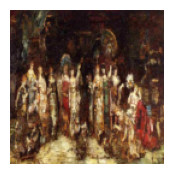

Ground truth: it looks like something important and exciting is happening                      
Generated text:  the people in the painting look like they are in pain .


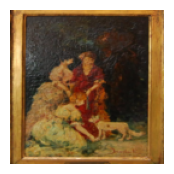

Ground truth: the dog is amusing                           
Generated text:  the woman ' s expression is very beautiful and the colors are beautiful .


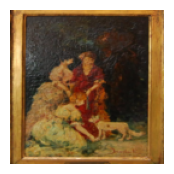

Ground truth: this makes me feel content because of the child ' s interaction and playfulness in the floor with the puppy .          
Generated text:  the woman ' s expression is very beautiful and the colors are beautiful .


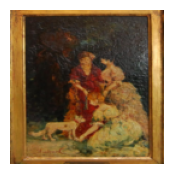

Ground truth: the soft strokes and blurred features make me feel at ease                    
Generated text:  the woman is wearing a red dress and the colors are very beautiful .


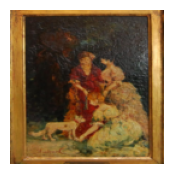

Ground truth: i ' m amused because im very interested to find out whats really <unk> in the picture .             
Generated text:  the woman is wearing a red dress and the colors are very beautiful .


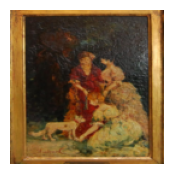

Ground truth: difficult to see faces and painting almost has a burning like <unk>                   
Generated text:  the woman is wearing a red dress and the colors are very beautiful .


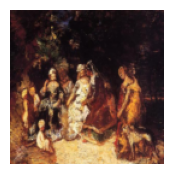

Ground truth: it has a <unk> i do not like . as if there are faces looking down from the top of the painting .        
Generated text:  the woman in the painting looks like she is in pain .


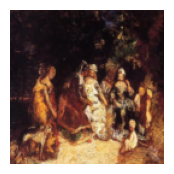

Ground truth: a lot going on in the painting                        
Generated text:  the woman in the painting looks like she is in pain .


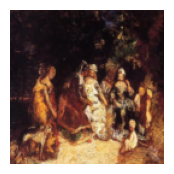

Ground truth: dark yet peaceful scene little fuzzy . peaceful scene                      
Generated text:  the woman in the painting looks like she is in pain .


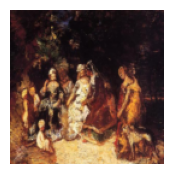

Ground truth: there is a <unk> , like people have just discovered a dark secret around the campfire . their expressions are jagged , like the paint strokes applied    
Generated text:  the woman in the painting looks like she is in pain .


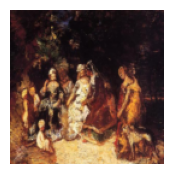

Ground truth: the picture looks blurry                           
Generated text:  the woman in the painting looks like she is in pain .


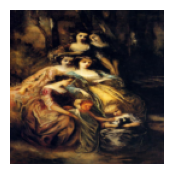

Ground truth: because the expressions of the people in the drawing .                     
Generated text:  the woman ' s expression is very beautiful and the way she is holding her head is holding her .


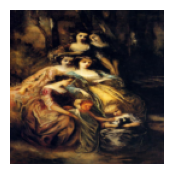

Ground truth: it ' s funny because they ' re all sitting on top of each other                
Generated text:  the woman ' s expression is very beautiful and the way she is holding her head is holding her .


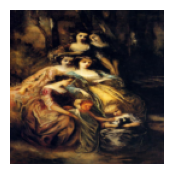

Ground truth: mother and child bond                           
Generated text:  the woman ' s expression is very beautiful and the way she is holding her head is holding her .


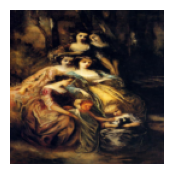

Ground truth: women of various ages seeming to drown in their <unk> .                    
Generated text:  the woman ' s expression is very beautiful and the way she is holding her head is holding her .


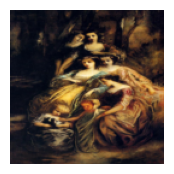

Ground truth: like how it goes dark at top to light at bottom also with the change of age of the ladies           
Generated text:  the woman is wearing a red dress and her red dress is very well done .


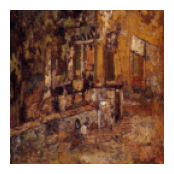

Ground truth: it looks like an abandoned cabin out in the woods .                    
Generated text:  the woman in the painting looks like she is in pain .


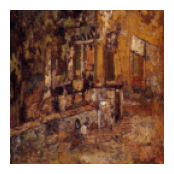

Ground truth: i can ' t really see what is going on so it makes the town look sinister              
Generated text:  the woman in the painting looks like she is in pain .


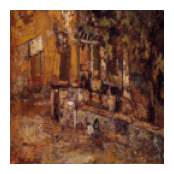

Ground truth: interested . the colors don ' t provide much detail on the setting but you keep meandering through it            
Generated text:  the people in the painting look like they are in pain .


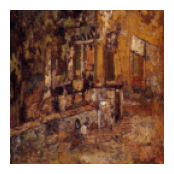

Ground truth: the scene is of a simple <unk> house . the colors are warm . the place looks inviting , sincere , and comforting .       
Generated text:  the woman in the painting looks like she is in pain .


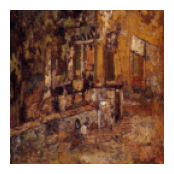

Ground truth: i feel curiosity because i want to know if what i am looking at is a building and rock wall with a tree on the right .    
Generated text:  the woman in the painting looks like she is in pain .


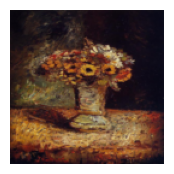

Ground truth: colorful flowers in a vase make me happy .                      
Generated text:  the woman ' s expression is very sad and the colors are beautiful .


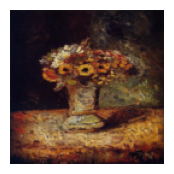

Ground truth: the thick brush strokes on the oil paint , as well as the still life of flowers in the vase make me think of a peaceful , <unk> room . 
Generated text:  the woman is wearing a red dress and the red on her head is very well done .


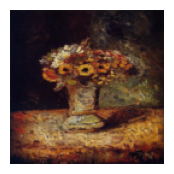

Ground truth: painting done clearly and it show clearly what it was . a flower pot with many flowers and kept on a table .        
Generated text:  the woman is wearing a red dress and the red on her head is very well done .


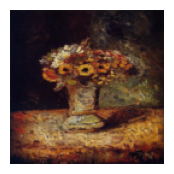

Ground truth: flowers are usually given because something happens                        
Generated text:  the woman is wearing a red dress and the red on her head is very well done .


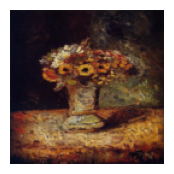

Ground truth: very calm and beautiful interesting texture                         
Generated text:  the woman is wearing a red dress and the red on her head is very well done .


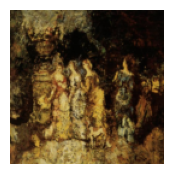

Ground truth: the colors are dull and the faces are too unclear                     
Generated text:  the people in the painting look like they are in pain .


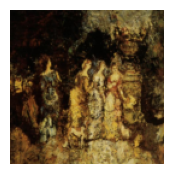

Ground truth: the faces are all looking one direction . they appear to be leaving on a fox hunt .             
Generated text:  the people in the painting look like they are in pain .


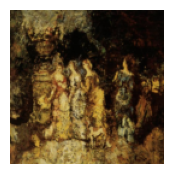

Ground truth: it looks like a terrible event is happening although i ' m not sure what exactly               
Generated text:  the people in the painting look like they are in pain .


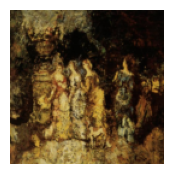

Ground truth: all of the women appear to have little to no expression on their faces .                
Generated text:  the people in the painting look like they are in pain .


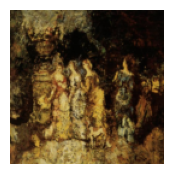

Ground truth: it looks like four women are all dressed up while a sudden gust of wind passes through them .            
Generated text:  the people in the painting look like they are in pain .


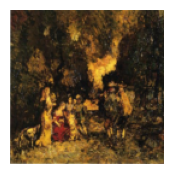

Ground truth: i feel calm looking at this art . it reminds me of a pleasant gathering on the weekend .            
Generated text:  the woman is wearing a red dress and the colors are very beautiful .


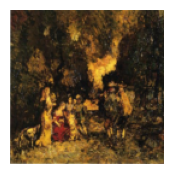

Ground truth: the people in the painting appear to be having a peaceful gathering .                  
Generated text:  the woman is wearing a red dress and the colors are very beautiful .


In [52]:
for i in range(64):
  idx = i
  plot_img(enc_batch[idx], target_batch[idx])
  generate(transformer, enc_batch[idx], device, maxlen)